In [ ]:
# DPB-Bert

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def scale_data(train_data, test_data):
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    return pd.DataFrame(scaled_train_data, columns=train_data.columns), pd.DataFrame(scaled_test_data, columns=test_data.columns)
 
def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc=False):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=10, return_train_score=True)
    grid_search.fit(X_train, y_train)
 
    best_model = grid_search.best_estimator_
 
    print(f"\nResults for {model.__class__.__name__} - Cross Validation:")
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []
    mean_accuracy_list = []
 
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
 
        fold_model = model.__class__(**best_model.get_params())
        fold_model.fit(X_train_fold, y_train_fold)
        predictions = fold_model.predict(X_val_fold)
 
        fpr, tpr, _ = roc_curve(y_val_fold, fold_model.predict_proba(X_val_fold)[:, 1])
        roc_auc = auc(fpr, tpr)
 
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Fold {fold} (AUC = {roc_auc:.2f})')
 
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tpr_list.append(interp_tpr)
        
        fold_accuracy = accuracy_score(y_val_fold, predictions)
        print(f"\nFold {fold} Accuracy: {fold_accuracy}")
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val_fold, predictions))
        mean_accuracy_list.append(fold_accuracy)
 
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model.__class__.__name__} (Cross Validation)')
    plt.legend(loc='lower right')
 
    if save_auroc:
        plt.savefig(f"{model.__class__.__name__}_CrossValidation_ROC.pdf")
    plt.show()
    plt.close()
 
    predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, predictions)
    test_roc_auc = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
 
    print("\nResults for", model.__class__.__name__, "- Testing:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("\nClassification Report:\n", classification_report(y_test, predictions))
 
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    print("Precision for Class 0:", precision[0])
    print("Recall for Class 0:", recall[0])
    print("F1-Score for Class 0:", f1[0])
 
    print("Precision for Class 1:", precision[1])
    print("Recall for Class 1:", recall[1])
    print("F1-Score for Class 1:", f1[1])
 
    print("\nMatthews Correlation Coefficient:", matthews_corrcoef(y_test, predictions))
    print("\nTest AUC Score:", auc(test_roc_auc[0], test_roc_auc[1]))


In [3]:
def svm_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.01, 0.1, 1, 10, 100, 1000]
    }
 
    svm_model = SVC(probability=True)
    train_and_evaluate(svm_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [4]:
def random_forest_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8, 16, 20]
    }
 
    rf_model = RandomForestClassifier()
    train_and_evaluate(rf_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [5]:
def adaboost_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
 
    adaboost_model = AdaBoostClassifier()
    train_and_evaluate(adaboost_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [6]:
def xgboost_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
 
    xgb_model = XGBClassifier()
    train_and_evaluate(xgb_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [7]:
def extratrees_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
 
    extratrees_model = ExtraTreesClassifier()
    train_and_evaluate(extratrees_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)


In [8]:
training_data = pd.read_csv("feature_a_training.csv", index_col=0)
testing_data = pd.read_csv("feature_a_testing.csv", index_col=0)

In [9]:
training_data

,0,1,2,3,4,5,6,7,8,9,...,477,478,479,480,481,482,483,484,485,Label
0,0.004044,0.000578,0.001155,0.006355,0.001155,0.002311,0.000578,0.004044,0.004622,0.003466,...,0.022646,0.021774,0.021876,0.022326,0.022119,0.022840,0.022136,0.021842,0.021633,1
1,0.008448,0.001056,0.002112,0.003168,0.006336,0.007392,0.002112,0.000000,0.003168,0.008448,...,0.022380,0.021570,0.022145,0.022265,0.022516,0.022120,0.022032,0.022376,0.021704,1
2,0.000000,0.003044,0.000000,0.003044,0.000000,0.001522,0.000000,0.000000,0.006088,0.004566,...,0.021909,0.022234,0.023185,0.022064,0.022583,0.023405,0.023008,0.022391,0.022678,1
3,0.021192,0.002649,0.007947,0.011921,0.002649,0.015894,0.000000,0.002649,0.000000,0.015894,...,0.022423,0.020768,0.022295,0.021881,0.022140,0.021656,0.022058,0.021656,0.021421,1
4,0.003494,0.000499,0.002246,0.002246,0.001747,0.003244,0.000998,0.003743,0.001997,0.004742,...,0.022511,0.022664,0.022727,0.023107,0.022857,0.022520,0.022927,0.022486,0.022358,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,0.005540,0.000000,0.005540,0.005540,0.000000,0.005540,0.000000,0.011080,0.005540,0.002770,...,0.022552,0.021728,0.022944,0.020155,0.022267,0.022240,0.022330,0.022037,0.022022,0
2514,0.009331,0.000000,0.004666,0.001555,0.001555,0.010886,0.001555,0.001555,0.001555,0.009331,...,0.023177,0.023117,0.022179,0.023702,0.022823,0.023098,0.022438,0.022426,0.022923,0
2515,0.006232,0.001039,0.005972,0.003635,0.004414,0.004674,0.002856,0.002597,0.002337,0.008310,...,0.021991,0.021540,0.021312,0.021837,0.021784,0.021963,0.021811,0.021495,0.021780,0
2516,0.006555,0.000000,0.005827,0.001457,0.000728,0.006555,0.001457,0.002185,0.002185,0.005098,...,0.021514,0.021641,0.021541,0.021668,0.022116,0.021416,0.021662,0.021191,0.021117,0


In [10]:
testing_data

,0,1,2,3,4,5,6,7,8,9,...,477,478,479,480,481,482,483,484,485,Label
0,0.046980,0.002237,0.008949,0.013423,0.008949,0.015660,0.002237,0.002237,0.002237,0.026846,...,0.021301,0.022539,0.023256,0.022649,0.022462,0.023110,0.023425,0.023627,0.022100,1
1,0.004016,0.000000,0.000000,0.004016,0.000000,0.008032,0.008032,0.000000,0.016064,0.000000,...,0.021634,0.023489,0.021734,0.022821,0.020435,0.023375,0.023242,0.020539,0.023697,1
2,0.018963,0.003793,0.002528,0.000000,0.003793,0.016435,0.003793,0.000000,0.003793,0.012642,...,0.021769,0.021863,0.021982,0.021978,0.021011,0.022549,0.022150,0.022434,0.022277,1
3,0.000459,0.000459,0.000000,0.000000,0.006431,0.002297,0.001837,0.004134,0.001837,0.004134,...,0.022183,0.021470,0.020569,0.021377,0.023071,0.021568,0.021535,0.022261,0.022579,1
4,0.001664,0.000555,0.001109,0.004992,0.002773,0.002773,0.001109,0.001664,0.003328,0.007210,...,0.021866,0.021958,0.021303,0.021680,0.021593,0.021996,0.021959,0.022162,0.021850,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.004739,0.001354,0.004062,0.004062,0.001354,0.002708,0.001354,0.002031,0.004062,0.007448,...,0.021052,0.020909,0.021390,0.022148,0.021266,0.021746,0.020895,0.020859,0.021457,0
626,0.000000,0.000000,0.005348,0.000000,0.000000,0.010695,0.005348,0.010695,0.005348,0.010695,...,0.021363,0.022239,0.021380,0.023163,0.023497,0.022057,0.022246,0.022066,0.022021,0
627,0.004552,0.001517,0.000000,0.006070,0.004552,0.001517,0.003035,0.003035,0.006070,0.007587,...,0.021813,0.023235,0.022251,0.022151,0.022525,0.022694,0.022418,0.021967,0.023467,0
628,0.005145,0.000643,0.003859,0.003215,0.003215,0.005145,0.000000,0.001929,0.001929,0.007717,...,0.021806,0.022097,0.022798,0.022181,0.022664,0.021996,0.022158,0.022275,0.022089,0


In [11]:
# Separate features and labels
X_train_data = training_data.drop('Label', axis=1)
y_train_data = training_data['Label']
X_test_data = testing_data.drop('Label', axis=1)
y_test_data = testing_data['Label']

In [12]:
scaled_X_train, scaled_X_test = scale_data(X_train_data, X_test_data)

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Results for RandomForestClassifier - Cross Validation:

Fold 1 Accuracy: 0.7559523809523809

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76       252
           1       0.75      0.76      0.76       252

    accuracy                           0.76       504
   macro avg       0.76      0.76      0.76       504
weighted avg       0.76      0.76      0.76       504


Fold 2 Accuracy: 0.751984126984127

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       252
           1       0.77      0.71      0.74       252

    accuracy                           0.75       504
   macro avg       0.75      0.75      0.75       504
weighted avg       0.75      0.75      0.75       504


Fold 3 Accuracy: 0.7638888888888888

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      

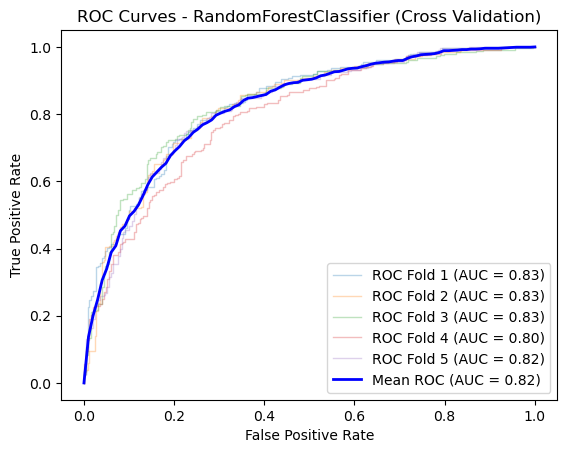


Results for RandomForestClassifier - Testing:
Accuracy: 0.7873015873015873

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77       315
           1       0.75      0.86      0.80       315

    accuracy                           0.79       630
   macro avg       0.79      0.79      0.79       630
weighted avg       0.79      0.79      0.79       630

Precision for Class 0: 0.8364312267657993
Recall for Class 0: 0.7142857142857143
F1-Score for Class 0: 0.7705479452054795
Precision for Class 1: 0.7506925207756233
Recall for Class 1: 0.8603174603174604
F1-Score for Class 1: 0.8017751479289941

Matthews Correlation Coefficient: 0.5808297248094438

Test AUC Score: 0.8598337112622826


In [14]:
random_forest_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


Results for AdaBoostClassifier - Cross Validation:

Fold 1 Accuracy: 0.7380952380952381

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       252
           1       0.72      0.77      0.75       252

    accuracy                           0.74       504
   macro avg       0.74      0.74      0.74       504
weighted avg       0.74      0.74      0.74       504


Fold 2 Accuracy: 0.7420634920634921

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       252
           1       0.75      0.72      0.74       252

    accuracy                           0.74       504
   macro avg       0.74      0.74      0.74       504
weighted avg       0.74      0.74      0.74       504


Fold 3 Accuracy: 0.746031746031746

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73

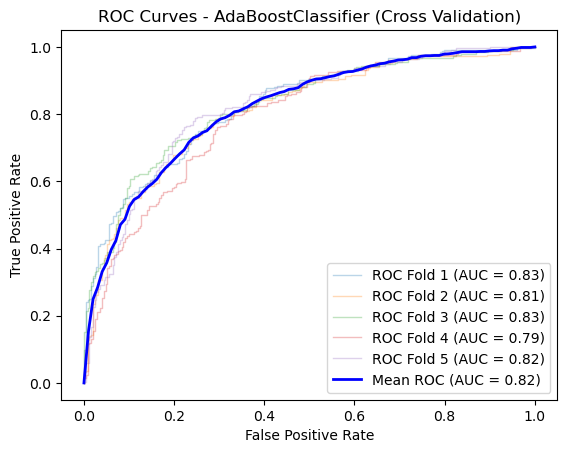


Results for AdaBoostClassifier - Testing:
Accuracy: 0.7761904761904762

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75       315
           1       0.74      0.86      0.79       315

    accuracy                           0.78       630
   macro avg       0.78      0.78      0.77       630
weighted avg       0.78      0.78      0.77       630

Precision for Class 0: 0.8346153846153846
Recall for Class 0: 0.6888888888888889
F1-Score for Class 0: 0.7547826086956522
Precision for Class 1: 0.7351351351351352
Recall for Class 1: 0.8634920634920635
F1-Score for Class 1: 0.7941605839416059

Matthews Correlation Coefficient: 0.5609985157906701

Test AUC Score: 0.8772688334593096


In [15]:
adaboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


Results for ExtraTreesClassifier - Cross Validation:

Fold 1 Accuracy: 0.7599206349206349

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76       252
           1       0.76      0.77      0.76       252

    accuracy                           0.76       504
   macro avg       0.76      0.76      0.76       504
weighted avg       0.76      0.76      0.76       504


Fold 2 Accuracy: 0.7698412698412699

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       252
           1       0.78      0.75      0.77       252

    accuracy                           0.77       504
   macro avg       0.77      0.77      0.77       504
weighted avg       0.77      0.77      0.77       504


Fold 3 Accuracy: 0.7619047619047619

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0

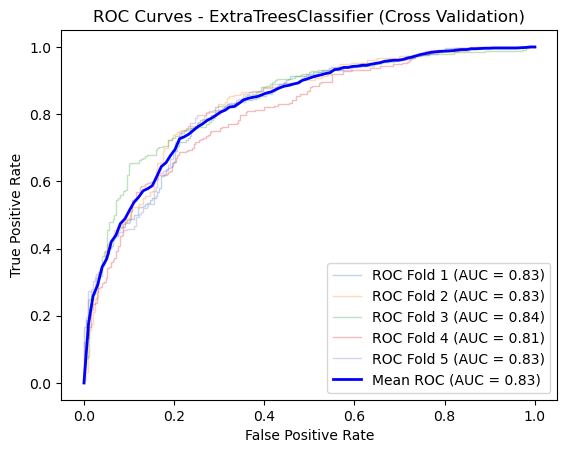


Results for ExtraTreesClassifier - Testing:
Accuracy: 0.7873015873015873

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77       315
           1       0.75      0.86      0.80       315

    accuracy                           0.79       630
   macro avg       0.79      0.79      0.79       630
weighted avg       0.79      0.79      0.79       630

Precision for Class 0: 0.8364312267657993
Recall for Class 0: 0.7142857142857143
F1-Score for Class 0: 0.7705479452054795
Precision for Class 1: 0.7506925207756233
Recall for Class 1: 0.8603174603174604
F1-Score for Class 1: 0.8017751479289941

Matthews Correlation Coefficient: 0.5808297248094438

Test AUC Score: 0.8717661879566642


In [16]:
extratrees_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

In [18]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


KeyboardInterrupt



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype)


Results for XGBClassifier - Cross Validation:


/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 1 Accuracy: 0.7678571428571429

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77       252
           1       0.77      0.77      0.77       252

    accuracy                           0.77       504
   macro avg       0.77      0.77      0.77       504
weighted avg       0.77      0.77      0.77       504



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 2 Accuracy: 0.746031746031746

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75       252
           1       0.76      0.73      0.74       252

    accuracy                           0.75       504
   macro avg       0.75      0.75      0.75       504
weighted avg       0.75      0.75      0.75       504



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 3 Accuracy: 0.7559523809523809

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76       252
           1       0.76      0.75      0.76       252

    accuracy                           0.76       504
   macro avg       0.76      0.76      0.76       504
weighted avg       0.76      0.76      0.76       504



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 4 Accuracy: 0.7375745526838966

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.73       251
           1       0.73      0.76      0.74       252

    accuracy                           0.74       503
   macro avg       0.74      0.74      0.74       503
weighted avg       0.74      0.74      0.74       503



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 5 Accuracy: 0.7534791252485089

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       252
           1       0.77      0.73      0.75       251

    accuracy                           0.75       503
   macro avg       0.75      0.75      0.75       503
weighted avg       0.75      0.75      0.75       503



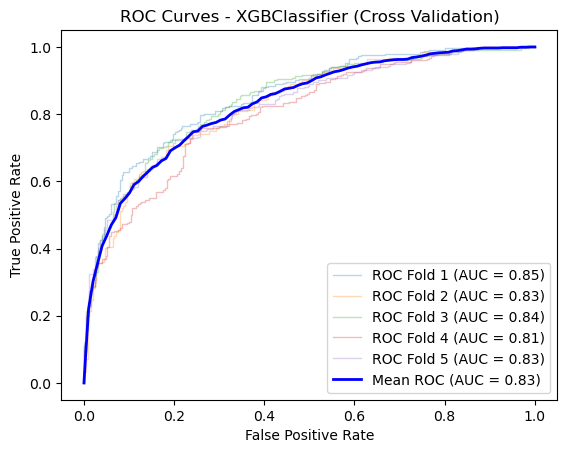


Results for XGBClassifier - Testing:
Accuracy: 0.8142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80       315
           1       0.78      0.88      0.83       315

    accuracy                           0.81       630
   macro avg       0.82      0.81      0.81       630
weighted avg       0.82      0.81      0.81       630

Precision for Class 0: 0.8613138686131386
Recall for Class 0: 0.7492063492063492
F1-Score for Class 0: 0.8013582342954159
Precision for Class 1: 0.7780898876404494
Recall for Class 1: 0.8793650793650793
F1-Score for Class 1: 0.8256333830104321

Matthews Correlation Coefficient: 0.633964456813042

Test AUC Score: 0.9021718316956413


/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

In [17]:
xgboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

In [30]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
random_forest_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
adaboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
xgboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
extratrees_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


KeyboardInterrupt

